# Blood Glucose prediction with EMSC as a preprocessing step

*Date: 09 June 2025*

**Objective**: To access the performance of EMSC as a preprocessing step for blood glucose prediction.

**Intuition**: Raman measurement is a linear combination of the spectra of the individual components.

$$ R = \sum_{i} c_{i} S_{i}  $$

where:
- $ R $ is the Raman measurement,
- $ c_{i} $ is the concentration level of component $ i $,
- $ S_{i} $ is the Raman spectrum of component $ i $.

In practice, the measurement $R$ could be skewed by a baseline which can be modeled as a polynomial function.

$$ R = \sum_{i} c_{i} S_{i}  + \sum_{j} a_{j} x^{j}$$

where:

- $ a_{j} $ is the coefficient of the polynomial of degree $ j $,
- $ x $ is the wavenumber.

Based on this idea, the Extended Multivariate Signal Correction (EMSC) will estimate the coefficients $ c_{i} $ and $ a_{j} $. 
This estimation can be seen as a linear regression problem where each $ S_{i} $ and $ x^{j} $ are the features and $ R $ is the target.

Any component $ S_{I} $ can be extracted from the measurement $ R $ with the following equation:

$$ \hat{S_{I}} = \frac{R  - \sum_{i \neq I} c_{i} S_{i}  - \sum_{j} a_{j} x^{j} }  {c_{I}} $$

where $ \hat{S_{I}} $ is an approximation of the actual component $ S_{I} $.



In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from itertools import groupby
from functools import reduce

from raman.spectra import Blood, Reference
from raman.sample import Sample
from datetime import datetime, timedelta

def get_figure():
    plt.figure(figsize=(10, 8))
    plt.xlabel("Raman Shift (cm^-1)")
    plt.ylabel("Intensity")
    plt.grid()

def get_colormap(start:int=0, end:int=1) -> plt.cm:
    cmap = colormaps.get_cmap("viridis")
    map = cmap(np.linspace(0, 1, end - start + 1))
    return map

def accumulate(s1:Sample,s2:Sample):
    return s1 | s2

from scipy.interpolate import CubicSpline
import numpy as np


## Let's Load all blood data

Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 3 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 1 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is perform automatically.
Found 2 spike(s) in path=, self.remove_spike() is p

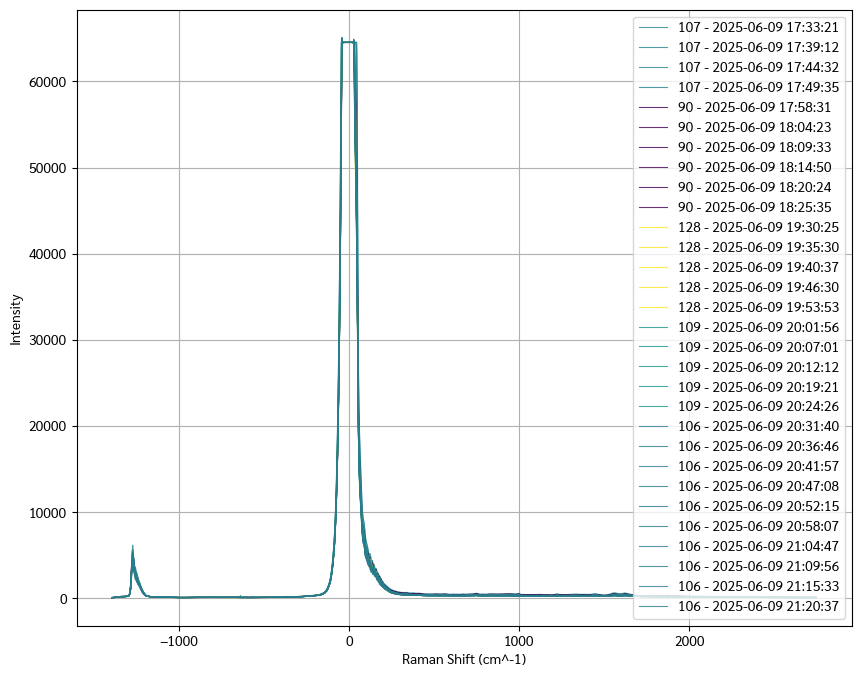

In [2]:
startdate = datetime(year=2025, month=6, day=9)
enddate = startdate + timedelta(days=1)
bloods = Blood.from_database_by_daterange(start=startdate, end=enddate)

# Then, coverts them into samples
glucoses: list[int] = []
samples: list[Sample] = []
for blood in bloods:
    glucoses.append(blood.glucose)
    sample = blood.to_sample()
    sample.name = str(blood.glucose)
    samples.append(sample)

get_figure()
# Plot
colors = get_colormap(start=min(glucoses), end=max(glucoses))
rank = np.arange(min(glucoses), max(glucoses) + 1)
for idx, sample in enumerate(samples):
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    sample.plot(label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
plt.legend()
plt.show()

## Select interest range


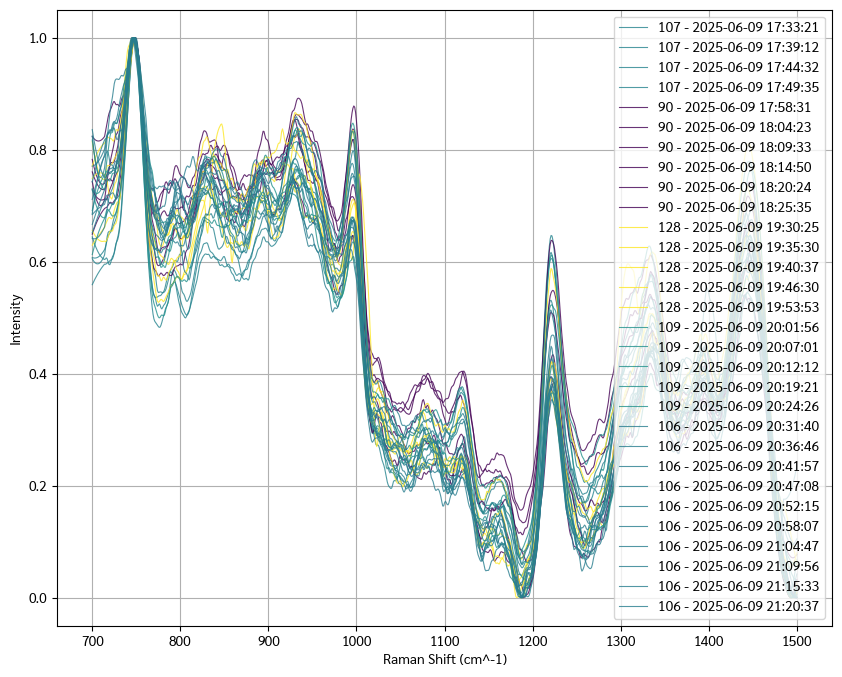

In [3]:
get_figure()
for idx, sample in enumerate(samples):
    sample.extract_range(low=700, high=1500)
    sample.smoothing()
    sample.normalized(method="minmax")
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    sample.plot(label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
plt.legend()
plt.show()

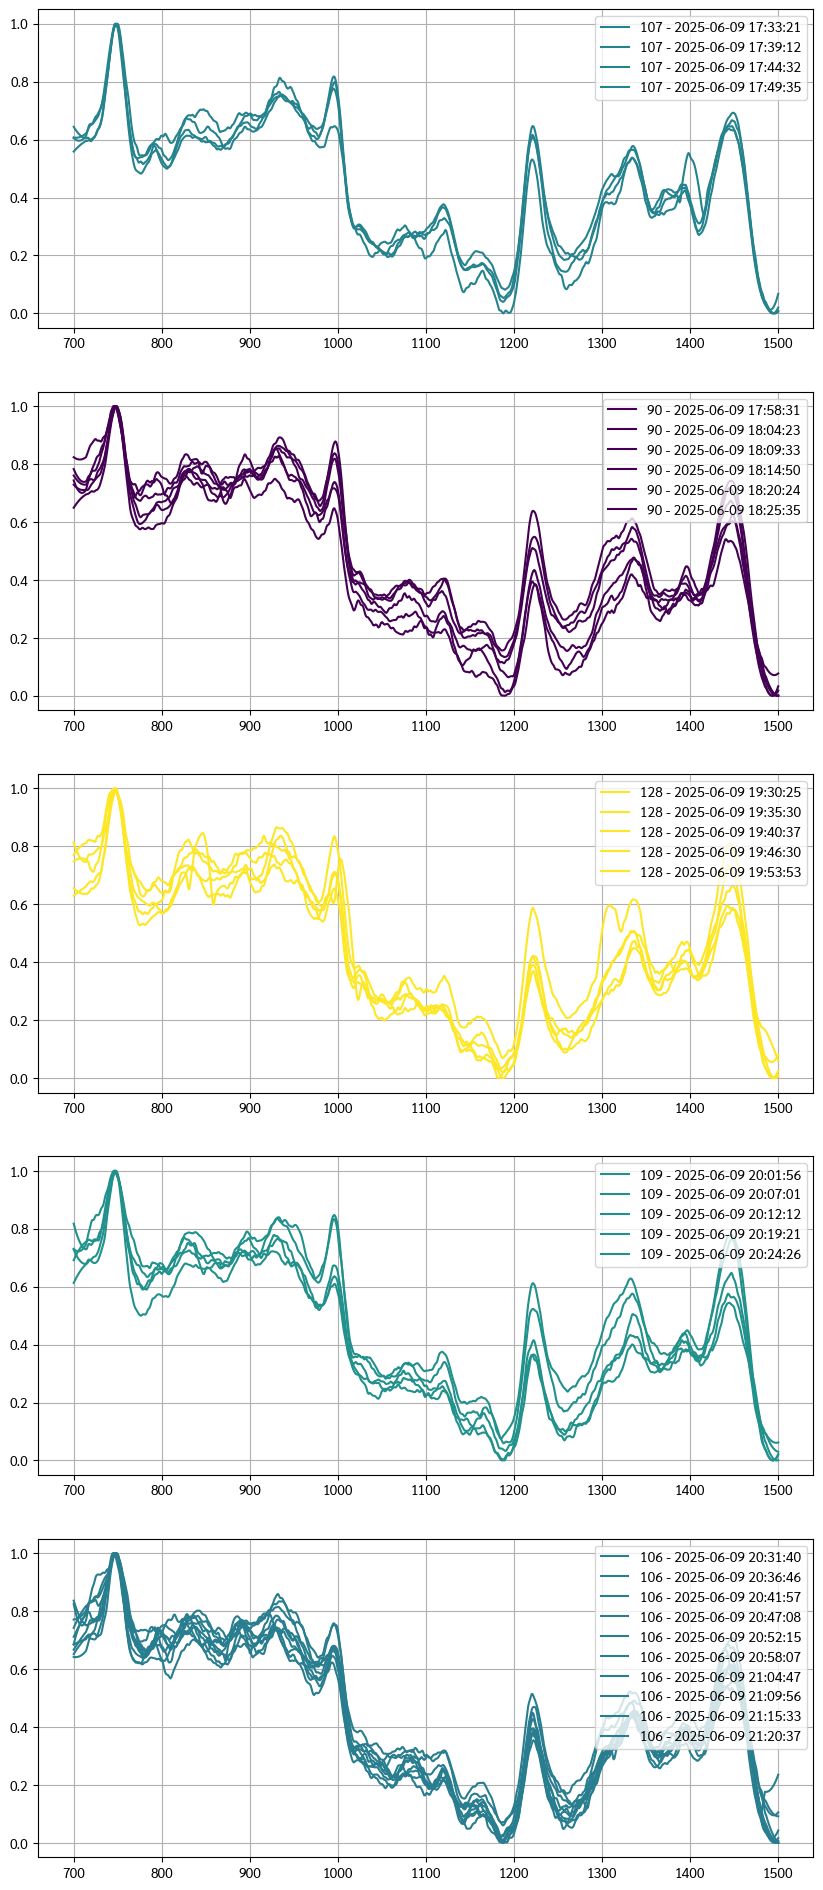

In [6]:
fig, ax = plt.subplots(figsize=(10, 24), nrows=5)
group_count = 0
current_value = None
for idx, sample in enumerate(samples):
    if(current_value is None):
        current_value = glucoses[idx]
    elif(current_value != glucoses[idx]):
        ax[group_count].grid()
        ax[group_count].legend(loc="upper right")
        group_count += 1
        current_value = glucoses[idx]
    
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    ax[group_count].plot(sample.x, sample.y, label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
    # ax[group_count].set_title(f"Sample {idx + 1}")
ax[group_count].grid()
ax[group_count].legend(loc="upper right")
plt.show()

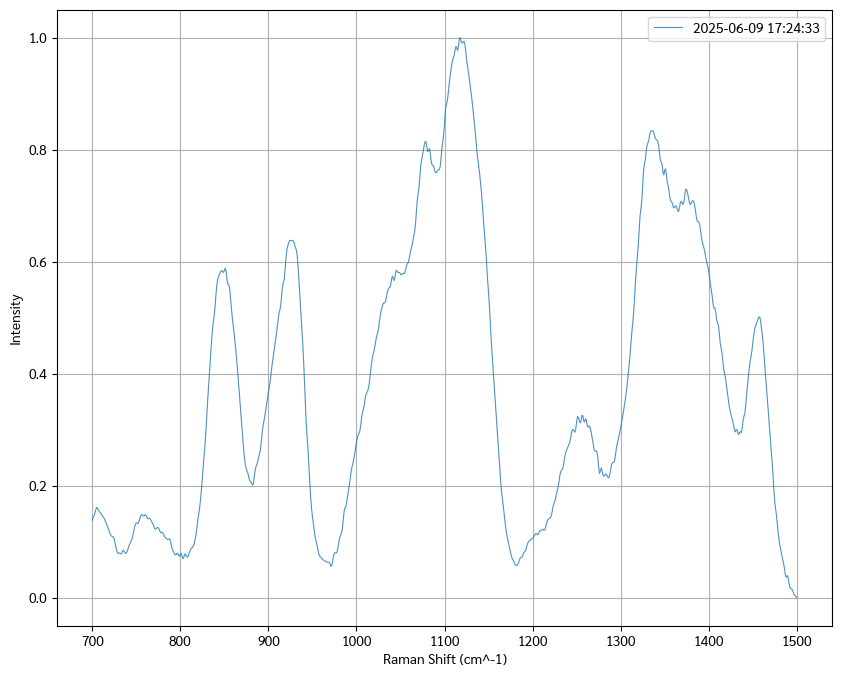

In [4]:
get_figure()
glucose_ref = Reference.from_database(name="glucose").to_sample()
glucose_ref.extract_range(low=700, high=1500)
glucose_ref.normalized(method="minmax")
glucose_ref.plot(label=f"{glucose_ref.date}")
plt.legend()
plt.show()

In [81]:
from raman.model import EMSC
def correction(sample: Sample) -> Sample:
    emsc = EMSC(raman_shift=sample.x, order=7)
    emsc.add_reference(glucose_ref.y, name="glucose")
    emsc.fit(composite_signal=sample.y)
    corrected_y = emsc.transform(composite_signal=sample.y)
    sample_corrected = Sample(
        x=sample.x,
        y=corrected_y,
        interpolate=False,
    )
    sample_corrected.name = f"{sample.name}_corrected"
    sample_corrected.date = sample.date
    return sample_corrected

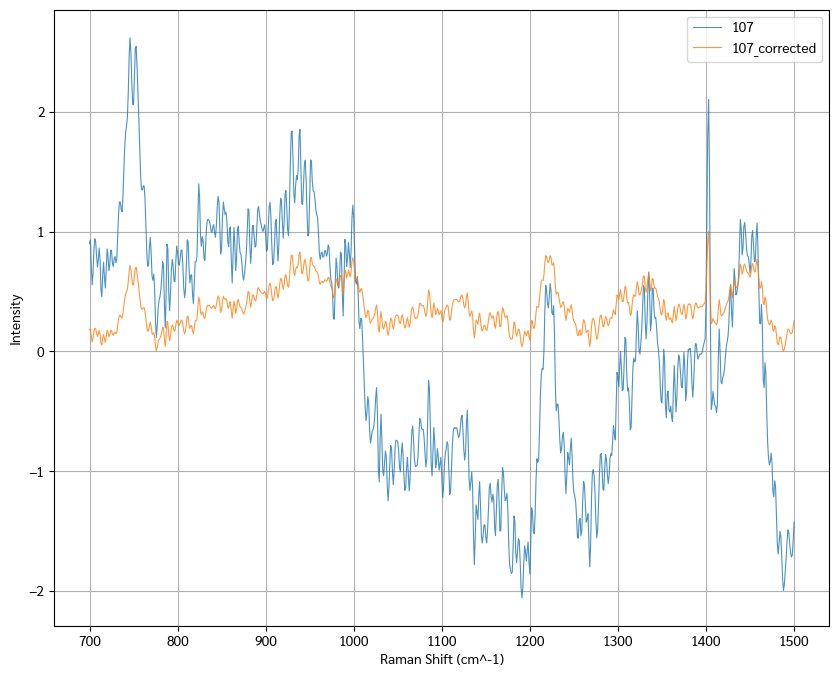

In [82]:
# Test correction with one sample
sample = samples[0]
sample_corrected = correction(sample)
get_figure()
sample.plot(label=f"{sample.name}")
# blood.plot(label=f"Blood")
sample_corrected.plot(label=f"{sample_corrected.name}")
plt.legend()
# add_plot_label()
plt.show()

In [83]:
# Do all coorection with all blood
samples_corrected = [correction(sample) for sample in samples]


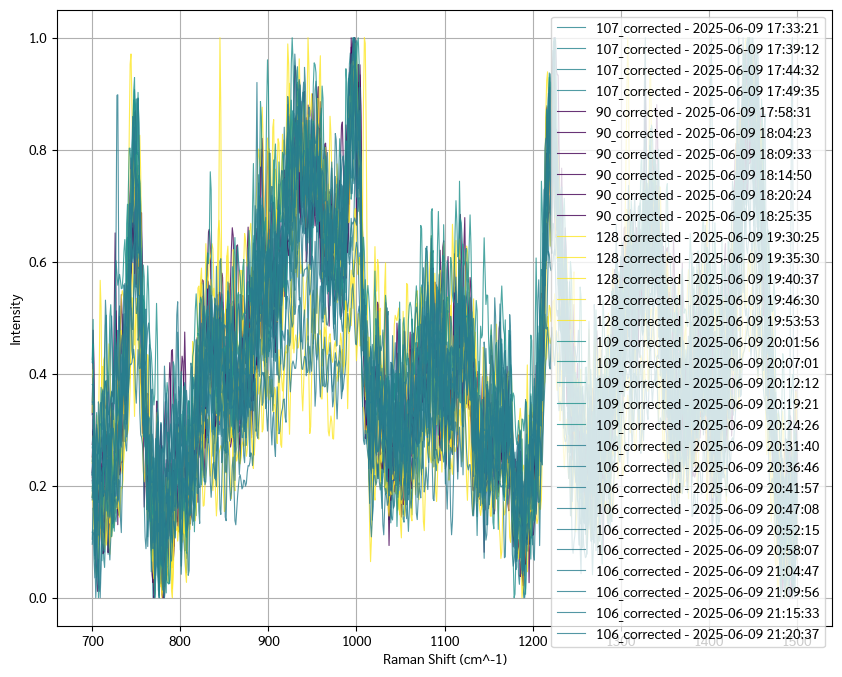

In [84]:
get_figure()
for idx, sample in enumerate(samples_corrected):
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    sample.plot(label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
plt.legend()
plt.show()

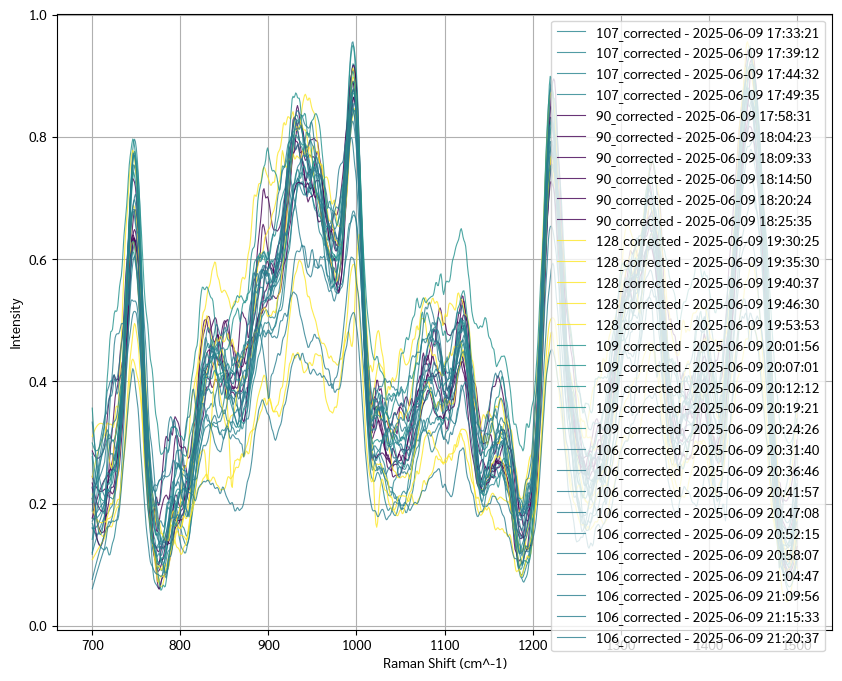

In [85]:
get_figure()
for idx, sample in enumerate(samples_corrected):
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    sample.smoothing()
    sample.plot(label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
plt.legend()
plt.show()

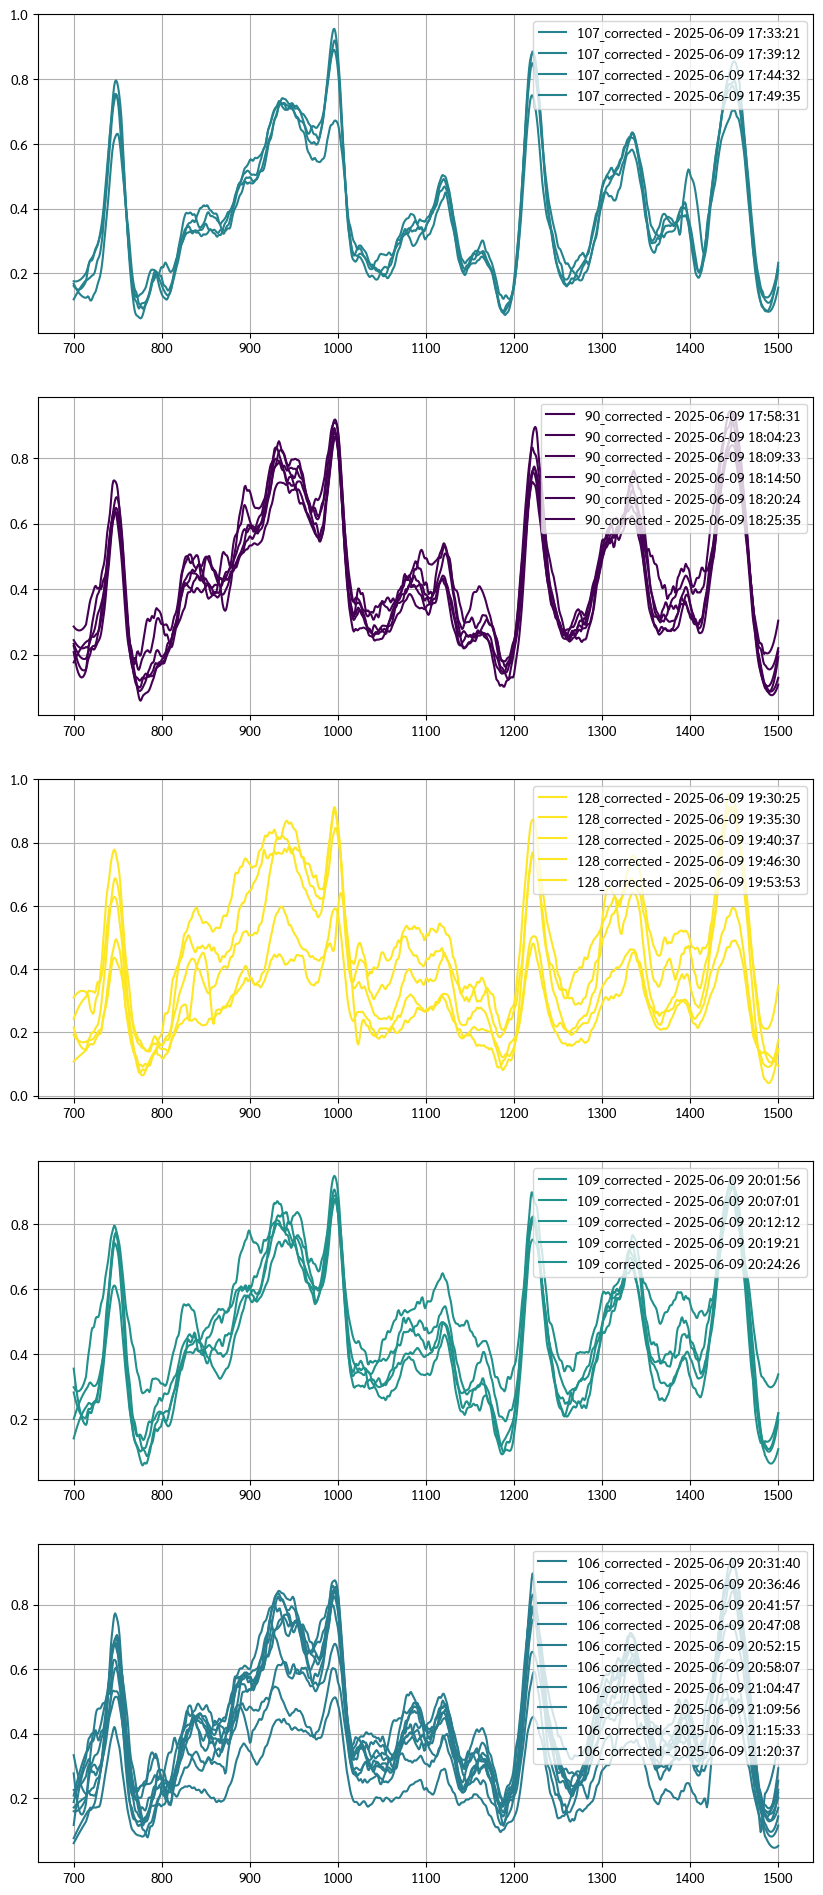

In [95]:
fig, ax = plt.subplots(figsize=(10, 24), nrows=5)
group_count = 0
current_value = None
for idx, sample in enumerate(samples_corrected):
    if(current_value is None):
        current_value = glucoses[idx]
    elif(current_value != glucoses[idx]):
        ax[group_count].grid()
        ax[group_count].legend(loc="upper right")
        group_count += 1
        current_value = glucoses[idx]
    
    color = colors[np.argwhere(glucoses[idx] == rank)[0][0]]
    ax[group_count].plot(sample.x, sample.y, label=f"{sample.name} - {sample.date.strftime('%Y-%m-%d %H:%M:%S')}", color=color) # type: ignore
    # ax[group_count].set_title(f"Sample {idx + 1}")
ax[group_count].grid()
ax[group_count].legend(loc="upper right")

Processing EMSC for all signal of S1

In [21]:
def correction(sample:Sample):
    emsc = EMSC(raman_shift=sample.x, order=4)
    emsc.add_reference(blood.y, name="blood")
    emsc.add_reference(skin.y, name="skin")
    # emsc.add_reference(glucose.y, name="glucose")
    emsc.fit(composite_signal=sample.y)
    corrected_y = emsc.transform(composite_signal=sample.y)
    sample_corrected = Sample(
        x=sample.x,
        y=corrected_y,
        interpolate=False,
    )
    sample_corrected.name = f"{sample.name}_corrected"
    return sample_corrected

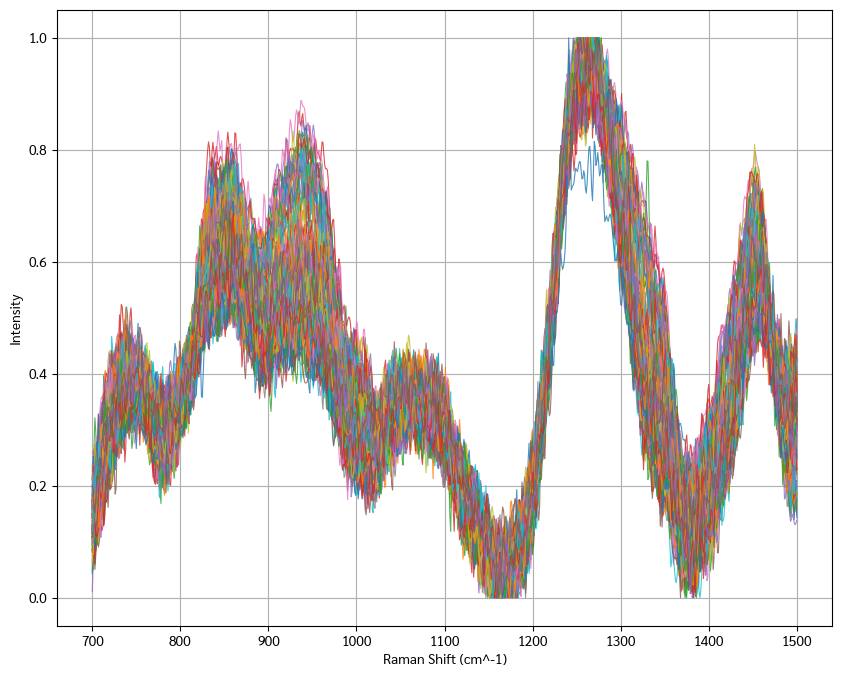

In [22]:
plt.figure(figsize=(10,8))

s_911s = []
s_1125s = []
s_1060s = []
s_1450s = []

corrected__samples = [ ]
for sample in data:
    corrected_sample = correction(sample)
    s_911s.append(corrected_sample.at(range(905,915)).mean())
    s_1125 = corrected_sample.at(range(1120,1130))
    s_1125s.append(s_1125.mean())
    s_1060s.append(corrected_sample.at(range(1050,1070)).mean())
    s_1450s.append(corrected_sample.at(range(1440,1460)).mean())
    
    corrected_sample.plot()
    corrected__samples.append(corrected_sample)

# plt.legend()
add_plot_label()
plt.show()


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
X = np.vstack([s_911s, s_1125s, s_1060s, s_1450s]).T
y = np.array(glucoses)
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
# rkf.get_n_splits(X,y)
models = [LinearRegression(), 
          RandomForestRegressor(), 
          GradientBoostingRegressor(), 
          AdaBoostRegressor()
        #   MLPRegressor()
          ]

mses = []
r2s = []
preds = []
best_r2 = -1

for model in models:
    best_mse = -1
    best_model = None
    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # r2 = r2_score(y_true=y_test, y_pred=y_pred)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        if mse < best_mse or best_mse == -1:
            best_mse = mse
            best_model = model

    y_pred = best_model.predict(X)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    mse = mean_squared_error(y_true=y, y_pred=y_pred)
    preds.append(y_pred)
    mses.append(mse)
    r2s.append(r2)
    if(r2 > best_r2):
        best_r2 = r2
    print(f"{model.__class__.__name__} mse: {mse:.3f} r2: {r2:.3f}")

print("Best model:", best_model)
print("Best r2:", best_r2)


LinearRegression mse: 1157.625 r2: 0.122
RandomForestRegressor mse: 172.718 r2: 0.869
GradientBoostingRegressor mse: 183.190 r2: 0.861
AdaBoostRegressor mse: 689.268 r2: 0.477
Best model: AdaBoostRegressor()
Best r2: 0.8689874376659377


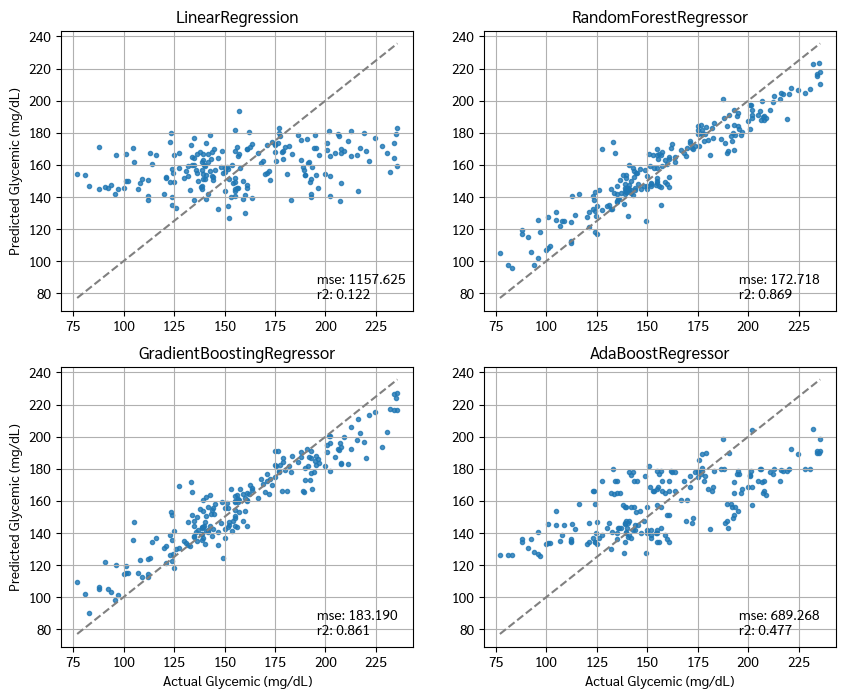

In [25]:
fig,ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)

idx = 0
for i in range(2):
    for j in range(2):

        start = min(y) if min(y) < min(preds[idx]) else min(preds[idx])
        end = max(y) if max(y) > max(preds[idx]) else max(preds[idx])
        ax[i][j].plot([start,end], [start,end], color='grey', linestyle='--')
        ax[i][j].scatter(x=y, y=preds[idx], alpha=0.8, marker='.')
        ax[i][j].grid()
        ax[i][j].set_title(f"{models[idx].__class__.__name__}")
        ax[i][j].text(x=end-40, y=start, s=f"mse: {mses[idx]:.3f}\nr2: {r2s[idx]:.3f}", fontsize=10)
        idx += 1


ax[0][0].set_ylabel("Predicted Glycemic (mg/dL)")
ax[1][0].set_ylabel("Predicted Glycemic (mg/dL)")
ax[1][0].set_xlabel("Actual Glycemic (mg/dL)")
ax[1][1].set_xlabel("Actual Glycemic (mg/dL)")

plt.show()